# Basic potential flow around a flat plate

In [234]:
using Plots
using LinearAlgebra
using LaTeXStrings
using GridPotentialFlow
using ConstrainedSystems

## Using ConstrainedSystems

The basic discrete potential flow problem is

$$L\psi = -w$$

with $\psi$ the streamfunction field and $w$ the vorticity field. In the JuliaIBPM suite, we discretize the flow domain and for our potential flow problem we initialize `ψ` and `w` as `Nodes`:

In [235]:
Δx = 0.01
xlim = (-1,1)
ylim = (-1,1)
g = PhysicalGrid(xlim,ylim,Δx)

w = Nodes(Dual,size(g))
ψ = Nodes(Dual,w);
L = plan_laplacian(size(w),with_inverse=true)

xg,yg = coordinates(w,g);

Similarly, we discretize the flat plate and store the points in `X` as `VectorData` and try to keep the ratio of the body points spacing to the grid spacing around 2 for smooth results later on.

In [236]:
n = 50

c = 1.0
body = Plate(c,n)

# Find the minimum arc length
Δs = minimum(dlength(body))
println("Ratio of arc spacing to cell size = ",Δs/Δx)

# Move the airfoil
xc = 0.0; yc = 0.0
α = π/6
Tr = RigidTransform((xc,yc),-α)
Tr(body);

X = VectorData(midpoints(body)[1][1:end],midpoints(body)[2][1:end]);
n = length(X.u);

Ratio of arc spacing to cell size = 2.0408163265306034


On the plate, the streamfunction is equal to a prescribed streamfunction $\psi_b$

$$ E\psi = \psi_b $$

In [237]:
ψb = ScalarData(X); # Prescribed streamfunction on the body

This condition is enforced using the lagrange multiplier $f$ in the potential flow problem

$$L\psi + Rf = -w$$

In [238]:
f = ScalarData(X); # Lagrange multiplier

$E$ is the interpolation operator from the grid to the body points and $R$ is the regularization operator from the body to the grid. We create them in matrix form as `Rmat` and `Emat`:

In [239]:
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true)
Rmat,Emat = RegularizationMatrix(regop,f,w);

The equations above can be reformulated as

$$\begin{bmatrix} L & R \\ E & 0 \end{bmatrix} \begin{bmatrix}\psi \\ f \end{bmatrix} = \begin{bmatrix} -w \\ \psi_b \end{bmatrix}$$

We can solve this system efficiently by defining a system `S` as a `SaddleSystem` from ConstrainedSystems

In [240]:
S = SaddleSystem(L,Emat,Rmat,SaddleVector(w,ψb))

Saddle system with 43264 states and 49 constraints and
   State vector of type Nodes{Dual,208,208,Float64,Array{Float64,2}}
   Constraint vector of type ScalarData{49,Float64,Array{Float64,1}}
   Elements of type Float64
using a Direct solver


In our example, we simulate a flat plate in uniform flow by superposing the flow around the flat plate moving the left with a uniform flow moving from the left to the right with the same velocity. 

In [241]:
U∞ = 1.0
ψb .= -U∞*(X.v .- body.cent[2]);

The system can then be solved using our system `S` and the backslash operator `\`

In [242]:
sol = S\SaddleVector(w,ψb);
ψ .= state(sol)
f .= constraint(sol)
ψtot = zero(ψ);
ψtot .= ψ .+ U∞*(yg' .- body.cent[2]);

Before we plot the results, we note that the Lagrange multiplier `f` is related to the bound vortex sheet strength $\gamma$ from analytical theory as

$$\frac{f}{\Delta s} \approx \gamma$$

The bound vortex sheet strength for a flat plate moving with unit translational velocity normal to the plate is (Eldredge2019 equation 8.83)

$$
\gamma_{\mathrm{bt}}^{(2)}(\xi)=-\frac{2 \xi}{\sqrt{1-\xi^2}}
$$

with $\xi$ the coordinate along the plate going from -1 at the leading edge to 1 at the trailing edge.

In [160]:
γbt(ξ) = (1 .- ξ.^2).^(-1/2).*(-2*ξ);

We now plot the streamfunction contours and compare `f/Δs` to the analytical result for the bound vortex sheet strength

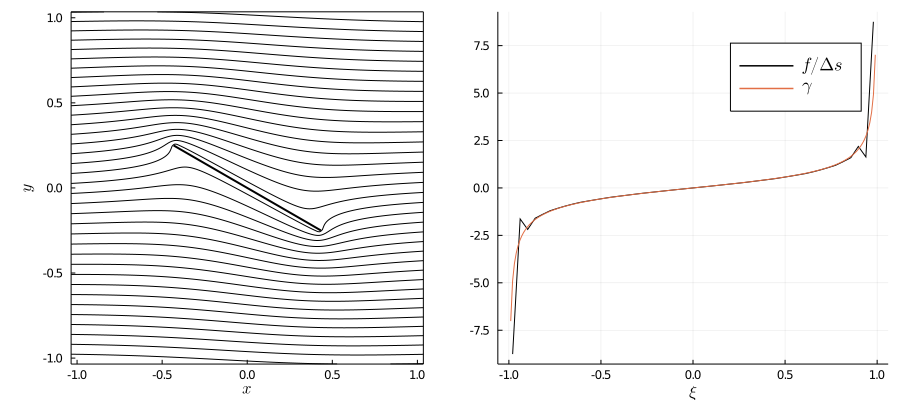

In [161]:
ψplot = plot(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2)
plot!(xg,yg,ψtot,linecolor=:black,levels=36,ylabel=latexstring("y"),xlabel=latexstring("x"),size=[400,400])
fplot = plot(size=[600,400])
plot!(sign.(X.u).*sqrt.(X.u.^2+X.v.^2)*(2/c),f/Δs,xlabel=latexstring("\\xi"),label=latexstring("f/\\Delta s"),linecolor=:black)

ξ = -1:0.01:1
plot!(ξ,γbt(ξ)*U∞*sin(-α),label=latexstring("\\gamma"),legendfontsize=12)

plot(ψplot, fplot, layout = (1,2), size = [900,400])

## Decomposing the bound vortex sheet strength into its singular and nonsingular part

The bound vortex sheet strength becomes singular towards the edges of the plate. This behavior is paired with the flow reaching infinite velocity while it turns around those edges, which is not realistic in a real flow with a sharp edge. However, the potential flow is nonunique and the potential flow theory provides an analytical solution to the problem of infinite velocity by adjusting the circulation about the plate such that the flow leaves the trailing edge of the plate smoothly, which is the well-known Kutta condition. In terms of the bound vortex sheet strength, this is equivalent to constraining the nonsingular part of the bound vortex sheet strength to be zero at the trailing edge. In our grid-based potential flow, we can follow a similar approach and decompose $f$ as a Hadamard product

$$ f = f_0 \circ \tilde{f}$$

$f_0$ contains the singular part and $\tilde{f}$ is smooth.

In [162]:
f₀ = ScalarData(X);
f̃ = ScalarData(X);

We can obtain the singular behavior of $f$ as the vortex sheet strength due to a uniform streamfunction on the body. In our case, we define $f_0$ as the discrete vortex sheet strength corresponding to a uniform, unit-strength streamfunction on the body. This is equivalent to specifying a circulation about the body with strength $\Gamma_0$, which is the integral of the vortex sheet strength and therefore also the sum of the elements in `f`.

In [163]:
ψb .= 1
w .= 0
sol = S\SaddleVector(w,ψb)
f₀ = constraint(sol);
Γ₀ = sum(f₀);

The vortex sheet strength associated with this uniform streamfunction is the vortex sheet strength due to a poin vortex centered at the origin of the circle plane (the image of a vortex at infinity). For a flat plate, this is equal to

$$ \gamma_0 = \frac{2\Gamma_0}{\pi c \sqrt{1-\xi^2}} $$

If we plot `f₀`, we see the singular behavior on both edges

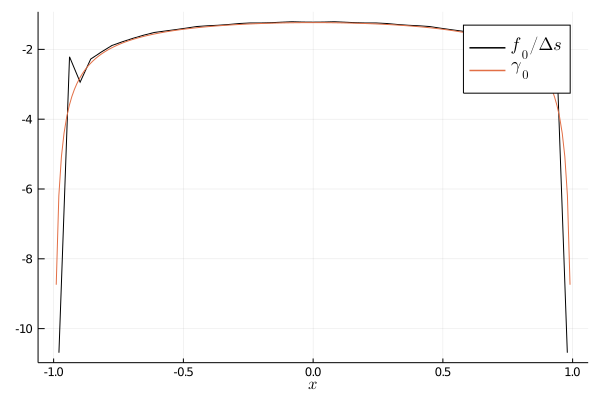

In [164]:
plot(-sign.(X.u).*sqrt.(X.u.^2+X.v.^2)*(2/c),f₀/Δs,xlabel=latexstring("x"),label=latexstring("f_{0}/\\Delta s"),linecolor=:black)
plot!(ξ,Γ₀./(π*c/2*sqrt.(1 .- ξ.^2)),label=latexstring("\\gamma_0"),legendfontsize=12)

To calculate `f̃`, we note that the Hadamard product can be rewritten as $f_0 \circ \tilde{f} = D_{f_0} \tilde{f}$. We can then absorb $D_{f_0}$ into the matrix $R$ (which operates on $f$) as

$$ Rf = RD_{f_0}\tilde{f} = \tilde{R}\tilde{f} $$

We replicate this modification on `Rmat` and obtain `R̃mat` which we use in a new system `S̃`

In [218]:
Df₀ = Diagonal(f₀);
R̃mat = deepcopy(Rmat);
R̃mat.M .= R̃mat.M*Df₀;
S̃ = SaddleSystem(L,Emat,R̃mat,SaddleVector(w,ψb))

Saddle system with 43264 states and 49 constraints and
   State vector of type Nodes{Dual,208,208,Float64,Array{Float64,2}}
   Constraint vector of type ScalarData{49,Float64,Array{Float64,1}}
   Elements of type Float64
using a Direct solver


Solving this system automatically gives us `f̃`

In [219]:
ψb .= -U∞*(X.v .- body.cent[2]);
sol = S̃\SaddleVector(w,ψb);
ψ .= state(sol)
f̃ .= constraint(sol)
ψtot = zero(ψ);
ψtot .= ψ .+ U∞*(yg' .- body.cent[2]);

If we plot `f̃`, we can confirm its smooth behavior

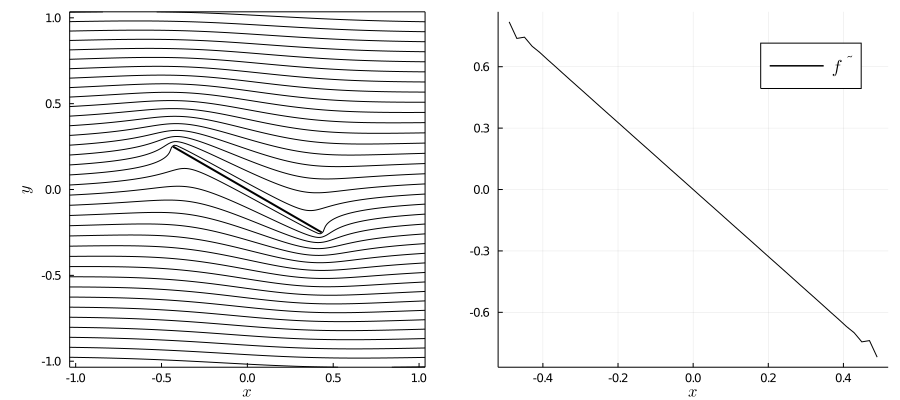

In [220]:
ψplot = plot(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2)
plot!(xg,yg,ψtot,linecolor=:black,levels=36)
plot!(ylabel=latexstring("y"),xlabel=latexstring("x"),size=[400,400])
fplot = plot(size=[600,400])
plot!(sign.(X.u).*sqrt.(X.u.^2+X.v.^2),f̃,xlabel=latexstring("x"),label=latexstring("\\tilde{f}"),linecolor=:black)
plot(ψplot, fplot, layout = (1,2), size = [900,400],legendfontsize=12)

If we reconstruct the Hadamard product as `Df₀*f̃`, we obtain again `f`

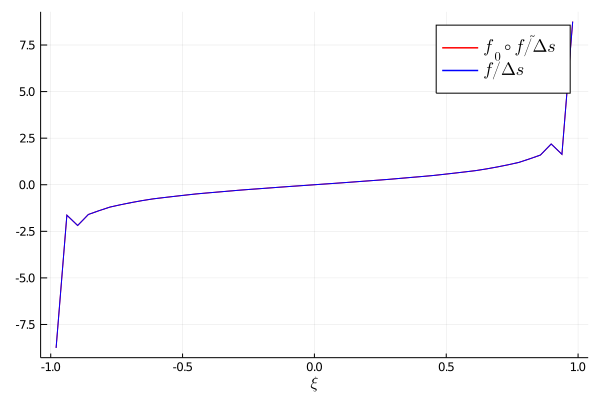

In [221]:
ξ = -1:0.01:1
plot(sign.(X.u).*sqrt.(X.u.^2+X.v.^2)*(2/c),Df₀*f̃/Δs,xlabel=latexstring("\\xi"),label=latexstring("f_0 \\circ \\tilde{f} / \\Delta s"),linecolor=:red)
plot!(sign.(X.u).*sqrt.(X.u.^2+X.v.^2)*(2/c),f/Δs,xlabel=latexstring("\\xi"),label=latexstring("f/\\Delta s"),linecolor=:blue,legendfontsize=12)

## Using GridPotentialFlow to regularize flow

TODO: PotentialFlowSystem with prescribed circulation

The flow around an impulsively accelerated flat-plate can be modeled by releasing vortex elements at the edges where the flow has to be regularized.

In this example, we look at the first instant after accelerating the plate and we place one point vortex in the flow near the trailing edge.

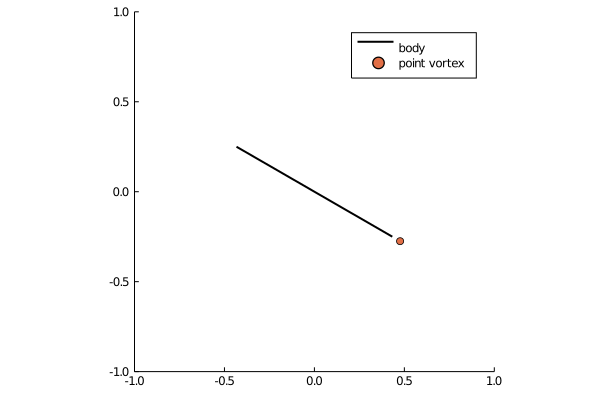

In [222]:
vk = Vortex(body.x[end]+0.05*c*cos(α),body.y[end]-0.05*c*sin(α),1.0);
plot(body,fillcolor=:black,fillrange=0,fillalpha=0,linecolor=:black,linewidth=2,xlimit=xlim,ylimits=ylim,label="body")
scatter!([vk.x],[vk.y],label="point vortex",legend=true)

To enforce the Kutta condition, we add the constraint that the smooth part of the bound vortex sheet strength $\tilde{f}$ has to be equal to zero at the edge that has to be regularized. We specify this constraint by introducing the unit vector $e_k$ which has the same length as $f$ and which is one at the $k$-th point and zero at every other point

$$ e_k^T \tilde{f} = 0 $$

In [223]:
ekvec = fill(ScalarData(n),1)
ekvec[1][n] = 1.5;
ekvec[1][n-1] = -0.5;

To preserve a net zero circulation in the flow, we add another constraint

$$ f_0^T \tilde{f} + \delta \Gamma_1 + \Gamma_w = 0 $$

with $\Gamma_w$ the circulation of the previously released vorticity, which is equal to zero in our case.

In [224]:
Γw = Δx^2*sum(w); # is equal to zero because no previously released vorticity

These constraints add two more langrange multipliers, the uniform value of the streamfunction on the body $\psi_0$ and the strength of the newly released vortex element $\delta\Gamma_1$.

In [225]:
ψ₀ = 0.0
δΓkvec = Array{Float64}(undef, 1);

The system for the potential flow problem that includes these constraints can be formulated as

$$\begin{bmatrix} L & \tilde{R} & 0 & \mathbf{d}_1 \\ E & 0 & \mathbf{1} & 0 \\ 0 & e_k^T & 0 & 0 \\ 0 & f_0^T & 0 & 1 \end{bmatrix} \begin{bmatrix}\psi \\ \tilde{f} \\ \psi_0 \\ \delta\Gamma_1 \end{bmatrix} = \begin{bmatrix} -w \\ \psi_b \\ 0 \\ -\Gamma_w\end{bmatrix}$$

The strength of the new vortex element is multiplying $\mathbf{d}_1$, which is the vorticity field of a unit-strength vortex element at the same position as our newly released vortex.

In [226]:
dk = Nodes(Dual,size(g));
Rdk =Regularize(VectorData([vk.x],[vk.y]),Δx,I0=origin(g),ddftype=CartesianGrids.Yang3)
Rdk(dk,ScalarData([1.0]));

Now we can compose the right-hand side and solution vector and generate the system using `PotentialFlowSystem` from this package.

In [227]:
ψb .= -U∞*(X.v .- body.cent[2]);
sol = (ψ,f̃,[ψ₀],δΓkvec)
rhs = (-w,ψb,[0.0],-Γw);
sys = PotentialFlowSystem(S̃,f₀,ekvec,[dk]);

The system can then be solved using backslash operator `\`

In [229]:
sol = sys\rhs;

In [230]:
ψ = sol[1]
f̃ = sol[2]
ψtot = zero(ψ);
ψtot .= ψ .+ U∞*(yg' .- body.cent[2]);

If we plot the solution, we see that the streamlines leave the trailing edge smoothly and that the smooth part of the vortex sheet strength is indeed zero at the trailing edge.

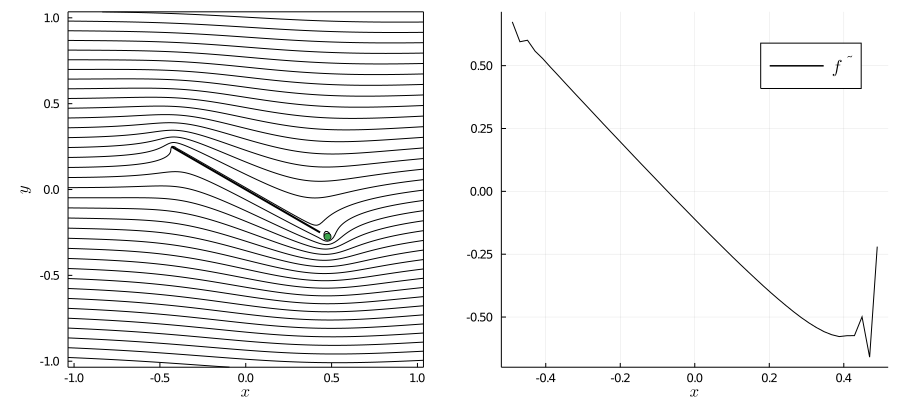

In [232]:
ψplot = plot(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2)
plot!(xg,yg,ψtot,linecolor=:black,levels=36)
plot!(ylabel=latexstring("y"),xlabel=latexstring("x"),size=[400,400])
scatter!([vk.x],[vk.y])
fplot = plot(size=[600,400])
plot!(sign.(X.u).*sqrt.(X.u.^2+X.v.^2),f̃,xlabel=latexstring("x"),label=latexstring("\\tilde{f}"),linecolor=:black)
plot(ψplot, fplot, layout = (1,2), size = [900,400],legendfontsize=12)